In [1]:
import argparse
import os

from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey
from jax import nn
from jax.lib import xla_bridge

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd
import numpy as np

import arviz as az
import bokeh
import matplotlib
import matplotlib.pyplot as plt

/home/DIDE/tmellan/anaconda3/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/home/DIDE/tmellan/anaconda3/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)
/home/DIDE/tmellan/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [9]:
from arviz.utils import conditional_jit, Numba
Numba.disable_numba()
Numba.numba_flag

False

In [2]:
NUM_CORES = 1
numpyro.set_host_device_count(NUM_CORES)
numpyro.set_platform('cpu')
print(xla_bridge.get_backend().platform)

cpu


In [3]:
df = pd.read_csv("../data/sim3.csv", header = None)
week = np.array(df.iloc[:,0])
data = np.array([df.iloc[:,1],df.iloc[:,2],df.iloc[:,3]]).T

trans_data =  np.round(100 * data)
trans_data[:,2] = 100 - (trans_data[:,0] + trans_data[:,1])
trans_data[:5]

array([[75.,  7., 18.],
       [67., 13., 20.],
       [59.,  8., 33.],
       [50., 12., 38.],
       [44., 12., 44.]])

### Probabilities

In [168]:
trans_data_p = trans_data

def dz_dt(z, 
          t, 
          inherent_growth_rate, 
          self_interaction,
          comp_interaction
         ):

    z1 = z[0]
    z2 = z[1]
    z3 = z[2]
    
    r1, r2 = (inherent_growth_rate[..., 0], 
              inherent_growth_rate[..., 1], 
             )
    
    a11, a22 = (self_interaction[..., 0], 
                self_interaction[..., 1], 
               )
    
    a12, a13, a21, a23 = (comp_interaction[..., 0], 
                                    comp_interaction[..., 1],
                                    comp_interaction[..., 2], 
                                    comp_interaction[..., 3], 
                                   )

    
    dz1_dt = r1 * z1 * (1 - (a11 * z1 + a12 * z2 + a13 * z3))
    dz2_dt = r2 * z2 * (1 - (a21 * z1 + a22 * z2 + a23 * z3))
    dz3_dt = - dz1_dt - dz2_dt
    
    return jnp.stack([dz1_dt, dz2_dt, dz3_dt])


def model(N : int, y = None):

    ts = jnp.arange(float(N))
    z_init = numpyro.sample("z_init", dist.Beta(1., 1.).expand([3]))
    

    inherent_growth_rate = numpyro.sample("inherent_growth_rate", 
                               dist.TruncatedNormal(
                                   low = 0.0,
                                   loc = jnp.repeat(1, 2),
                                   scale = jnp.repeat(1, 2),
                                   )
                              )
        

    self_interaction = numpyro.sample("self_interaction", 
                               dist.TruncatedNormal(
                                   low = 0.0,
                                   loc = jnp.repeat(1, 2),
                                   scale = jnp.repeat(1, 2),
                                   )
                              )
        

    comp_interaction = numpyro.sample("comp_interaction", 
                               dist.TruncatedNormal(
                                   low = 0.0,
                                   loc = jnp.repeat(1/10, 4),
                                   scale = jnp.repeat(1/10, 4),
                                   )
                              )

    
    z = odeint(dz_dt, z_init, ts, inherent_growth_rate, self_interaction,
          comp_interaction, rtol = 1e-7, atol = 1e-6, mxstep = 1000)
    numpyro.sample("y", dist.Multinomial(probs = z, total_count = 100), obs = y)
    
    
mcmc = MCMC(
    NUTS(model, dense_mass = True),
    num_samples = 100,
    num_warmup = 100,
    num_chains = NUM_CORES,
    progress_bar = True,
)

mcmc.run(PRNGKey(1), N = trans_data_p.shape[0], y = trans_data_p)
mcmc.print_summary()

sample: 100%|██████████| 200/200 [00:40<00:00,  4.64it/s, 1023 steps of size 2.99e-03. acc. prob=0.98]



                             mean       std    median      5.0%     95.0%     n_eff     r_hat
    comp_interaction[0]      0.32      0.01      0.33      0.31      0.34     46.37      1.04
    comp_interaction[1]      0.42      0.03      0.42      0.37      0.46     16.11      1.07
    comp_interaction[2]      0.44      0.03      0.44      0.39      0.49     17.59      1.06
    comp_interaction[3]      0.29      0.01      0.30      0.28      0.32     17.59      1.06
inherent_growth_rate[0]      1.31      0.44      1.24      0.70      1.95     12.37      1.10
inherent_growth_rate[1]      1.60      0.57      1.53      0.84      2.40     17.59      1.10
    self_interaction[0]      0.24      0.03      0.24      0.20      0.29     17.81      1.05
    self_interaction[1]      0.34      0.00      0.33      0.33      0.34     60.19      1.04
              z_init[0]      1.00      0.00      1.00      1.00      1.00      4.91      1.56
              z_init[1]      1.00      0.00      1.00      

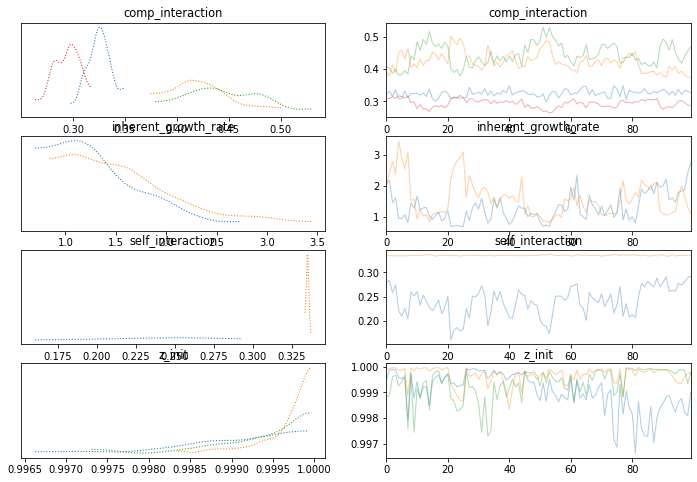

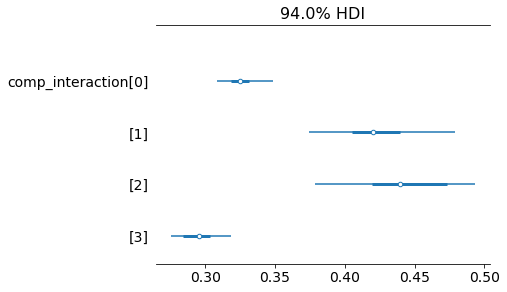

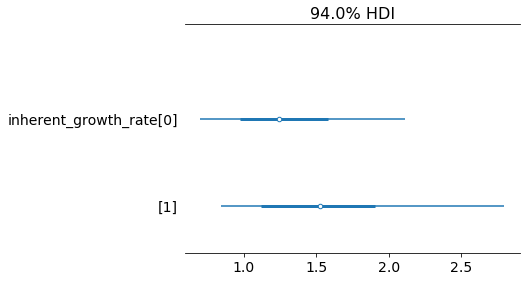

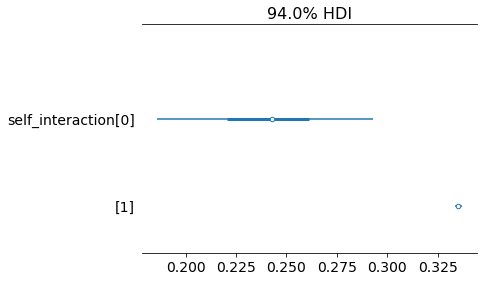

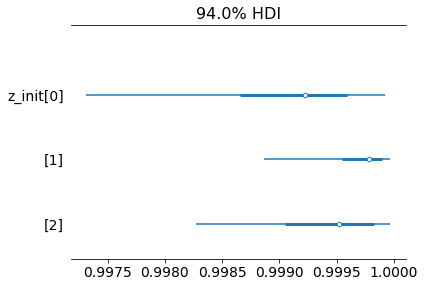

/home/DIDE/tmellan/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/pairplot.py:242: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  UserWarning,


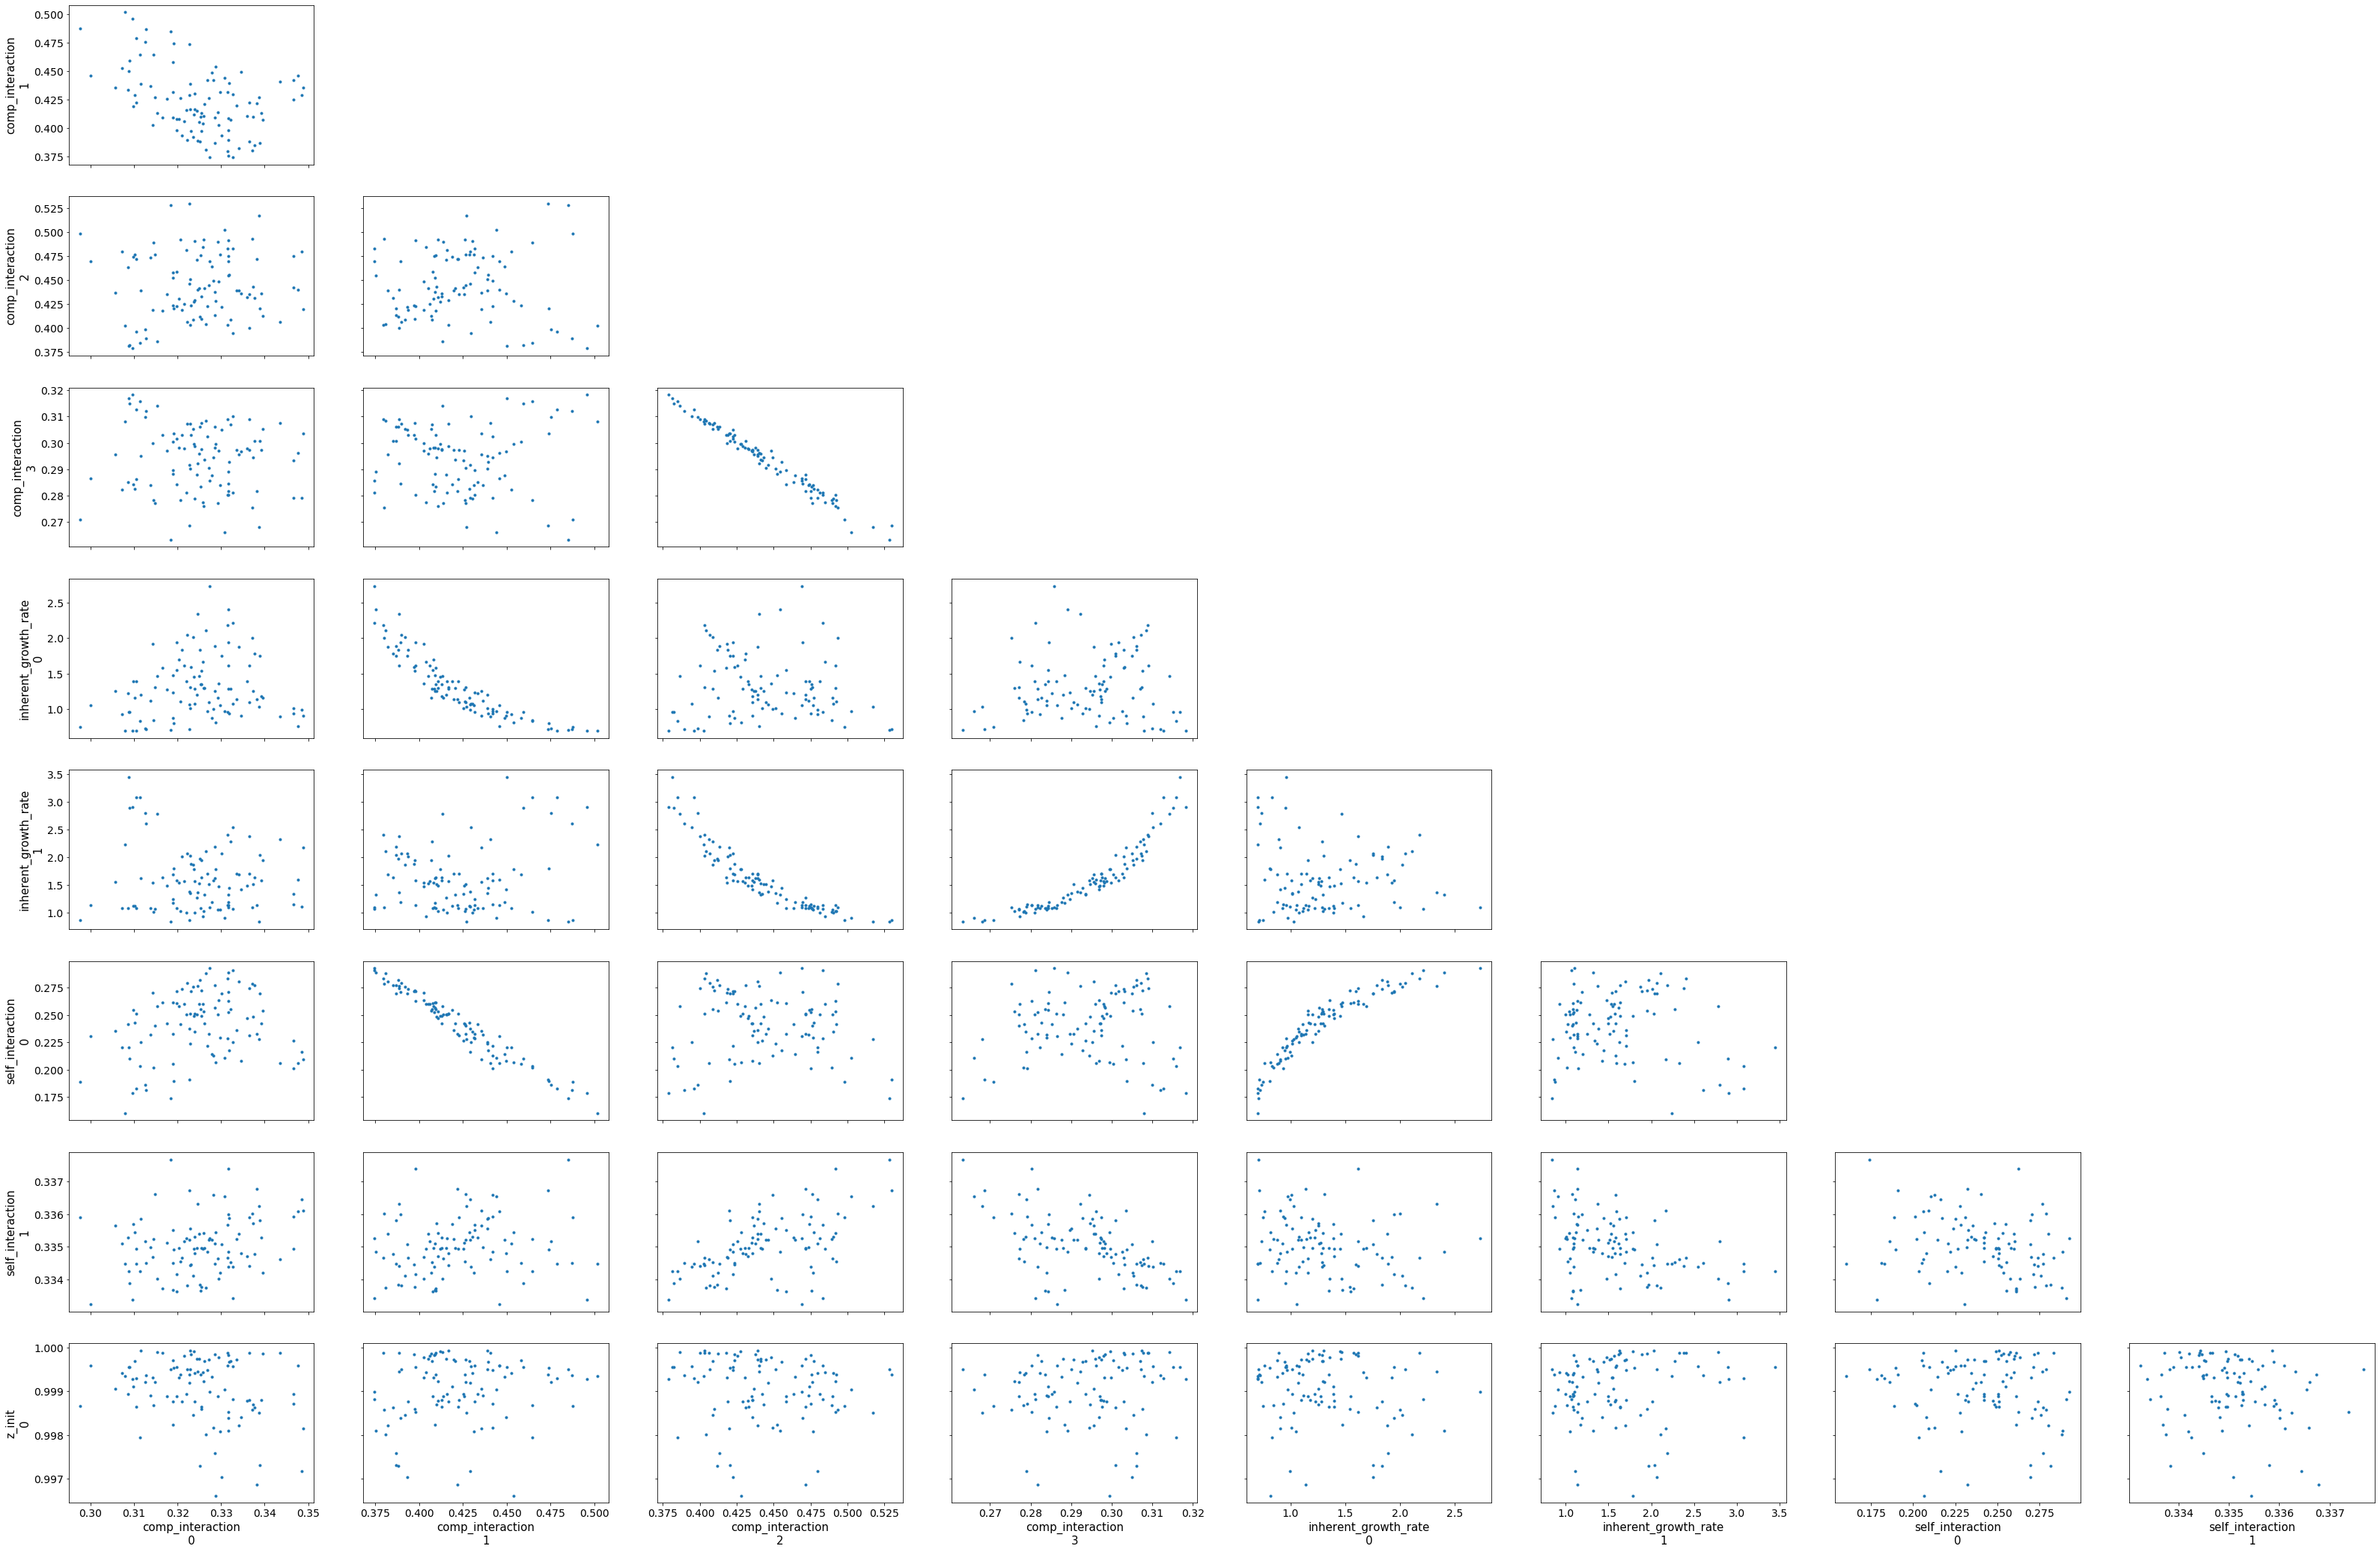

In [169]:
mcmc_from_numpyro = az.from_numpyro(mcmc)
az.plot_trace(mcmc_from_numpyro, compact = True, combined = True);
plt.show()

az.plot_forest(mcmc_from_numpyro, var_names = ['comp_interaction'], combined = True)
plt.show()

az.plot_forest(mcmc_from_numpyro, var_names = ['inherent_growth_rate'], combined = True)
plt.show()

az.plot_forest(mcmc_from_numpyro, var_names = ['self_interaction'], combined = True)
plt.show()

az.plot_forest(mcmc_from_numpyro, var_names = ['z_init'], combined = True)
plt.show()

az.plot_pair(mcmc_from_numpyro)
plt.show()

In [170]:
pop_pred

DeviceArray([[[100.,   0.,   0.],
              [100.,   0.,   0.],
              [100.,   0.,   0.],
              ...,
              [  0., 100.,   0.],
              [  0., 100.,   0.],
              [  0., 100.,   0.]],

             [[100.,   0.,   0.],
              [100.,   0.,   0.],
              [100.,   0.,   0.],
              ...,
              [  0., 100.,   0.],
              [  0., 100.,   0.],
              [  0., 100.,   0.]],

             [[100.,   0.,   0.],
              [100.,   0.,   0.],
              [100.,   0.,   0.],
              ...,
              [  0., 100.,   0.],
              [  0., 100.,   0.],
              [  0., 100.,   0.]],

             ...,

             [[100.,   0.,   0.],
              [100.,   0.,   0.],
              [100.,   0.,   0.],
              ...,
              [  0., 100.,   0.],
              [  0., 100.,   0.],
              [  0., 100.,   0.]],

             [[100.,   0.,   0.],
              [100.,   0.,   0.],
             

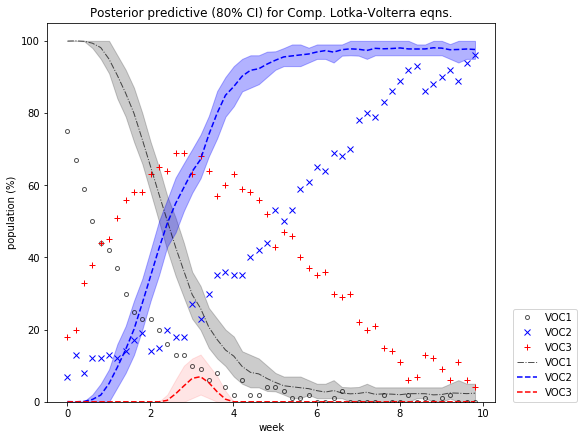

In [172]:
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), trans_data_p.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), np.percentile(pop_pred, (10, 90), 0)

plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(week, trans_data_p[:, 0], "ko", mfc="none", ms=4, label="VOC1", alpha=0.67)
plt.plot(week, trans_data_p[:, 1], "bx", label="VOC2")
plt.plot(week, trans_data_p[:, 2], "r+", label="VOC3")
# plt.plot(week, trans_data[:, 3], "g+", label="VOC4")
plt.plot(week, mu[:, 0], "k-.", label="VOC1", lw=1, alpha=0.67)
plt.plot(week, mu[:, 1], "b--", label="VOC2")
plt.plot(week, mu[:, 2], "r--", label="VOC3")
# plt.plot(week, mu[:, 3], "g--", label="VOC4")
plt.fill_between(week, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(week, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.fill_between(week, pi[0, :, 2], pi[1, :, 2], color="r", alpha=0.1)
# plt.fill_between(week, pi[0, :, 3], pi[1, :, 3], color="g", alpha=0.1)
plt.gca().set(ylim=(0, 105), xlabel="week", ylabel="population (%)")
plt.title("Posterior predictive (80% CI) for Comp. Lotka-Volterra eqns.")
plt.legend(loc=(1.04,0))
plt.show()

## Logits

In [175]:
def dz_dt(z, 
          t, 
          inherent_growth_rate, 
          self_interaction,
          comp_interaction
         ):

    z1 = z[0]
    z2 = z[1]
    z3 = z[2]
    
    r1, r2 = (inherent_growth_rate[..., 0], 
                  inherent_growth_rate[..., 1], 
                 )
    
    a11, a22 = (self_interaction[..., 0], 
                     self_interaction[..., 1], 
                    )
    
    a12, a13, a21, a23 = (comp_interaction[..., 0], 
                                    comp_interaction[..., 1],
                                    comp_interaction[..., 2], 
                                    comp_interaction[..., 3], 
                                   )

    
    dz1_dt = r1 * z1 * (1 - (a11 * z1 + a12 * z2 + a13 * z3))
    dz2_dt = r2 * z2 * (1 - (a21 * z1 + a22 * z2 + a23 * z3))
    dz3_dt = - dz1_dt - dz2_dt
    
    return jnp.stack([dz1_dt, dz2_dt, dz3_dt])


def model(N : int, y = None):

    ts = jnp.arange(float(N))
    
    z_init = numpyro.sample("z_init", dist.LogNormal(1, 1.).expand([3]))
    

    inherent_growth_rate = numpyro.sample("inherent_growth_rate", 
                               dist.TruncatedNormal(
                                   low = 0.0,
                                   loc = jnp.repeat(1, 2),
                                   scale = jnp.repeat(1, 2),
                                   )
                              )
        

    self_interaction = numpyro.sample("self_interaction", 
                               dist.TruncatedNormal(
                                   low = 0.0,
                                   loc = jnp.repeat(1, 2),
                                   scale = jnp.repeat(1, 2),
                                   )
                              )
        

    comp_interaction = numpyro.sample("comp_interaction", 
                               dist.TruncatedNormal(
                                   low = 0.0,
                                   loc = jnp.repeat(0.001, 4),
                                   scale = jnp.repeat(0.001, 4),
                                   )
                              )

    
    z = odeint(dz_dt, z_init, ts, inherent_growth_rate, self_interaction,
          comp_interaction, rtol = 1e-7, atol = 1e-6, mxstep = 1000)
    numpyro.sample("y", dist.Multinomial(logits = z, total_count = 100), obs = y)
    
    
mcmc = MCMC(
    NUTS(model, dense_mass = True),
    num_samples = 100,
    num_warmup = 100,
    num_chains = NUM_CORES,
    progress_bar = True,
)

mcmc.run(PRNGKey(1), N = trans_data.shape[0], y = trans_data)
mcmc.print_summary()

sample: 100%|██████████| 200/200 [00:31<00:00,  5.82it/s, 1023 steps of size 4.43e-03. acc. prob=0.94]



                             mean       std    median      5.0%     95.0%     n_eff     r_hat
    comp_interaction[0]      0.00      0.00      0.00      0.00      0.00     23.20      0.99
    comp_interaction[1]      0.00      0.00      0.00      0.00      0.00     57.02      1.01
    comp_interaction[2]      0.00      0.00      0.00      0.00      0.00     19.70      0.99
    comp_interaction[3]      0.00      0.00      0.00      0.00      0.00     26.21      1.02
inherent_growth_rate[0]      0.00      0.00      0.00      0.00      0.01     51.01      1.02
inherent_growth_rate[1]      0.03      0.00      0.03      0.02      0.03     52.09      0.99
    self_interaction[0]      1.28      0.64      1.16      0.25      2.13     60.30      1.03
    self_interaction[1]      0.07      0.01      0.07      0.05      0.09     50.27      0.99
              z_init[0]      7.65      0.92      7.52      6.34      8.73     71.52      1.01
              z_init[1]      5.08      0.92      4.90      

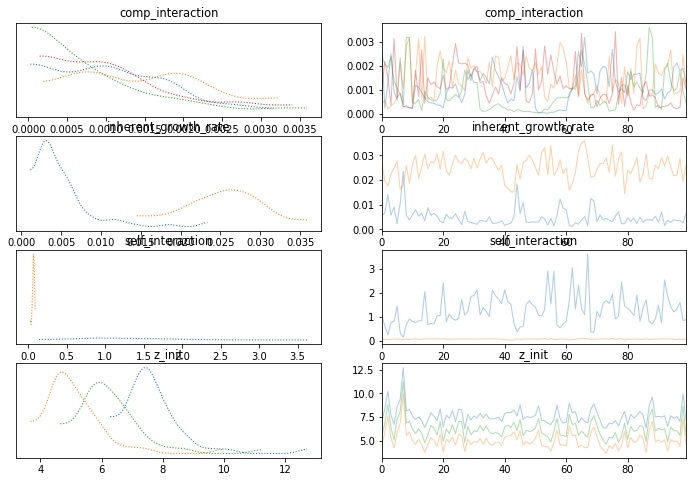

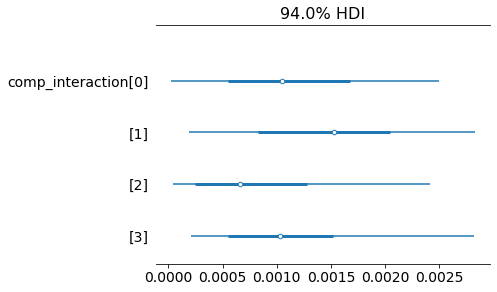

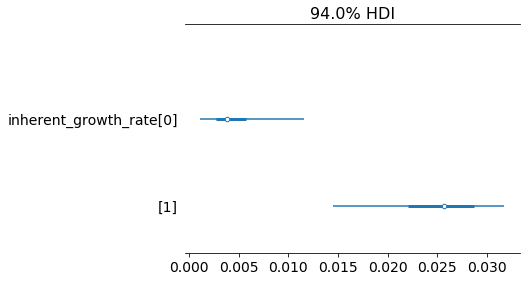

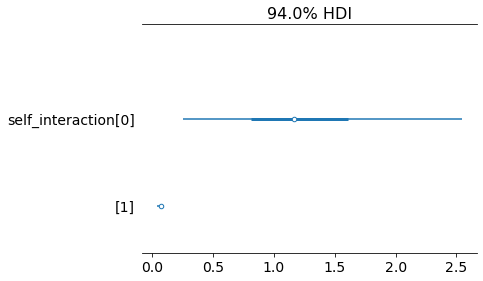

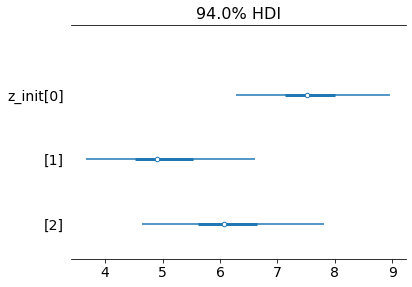

/home/DIDE/tmellan/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/pairplot.py:242: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  UserWarning,


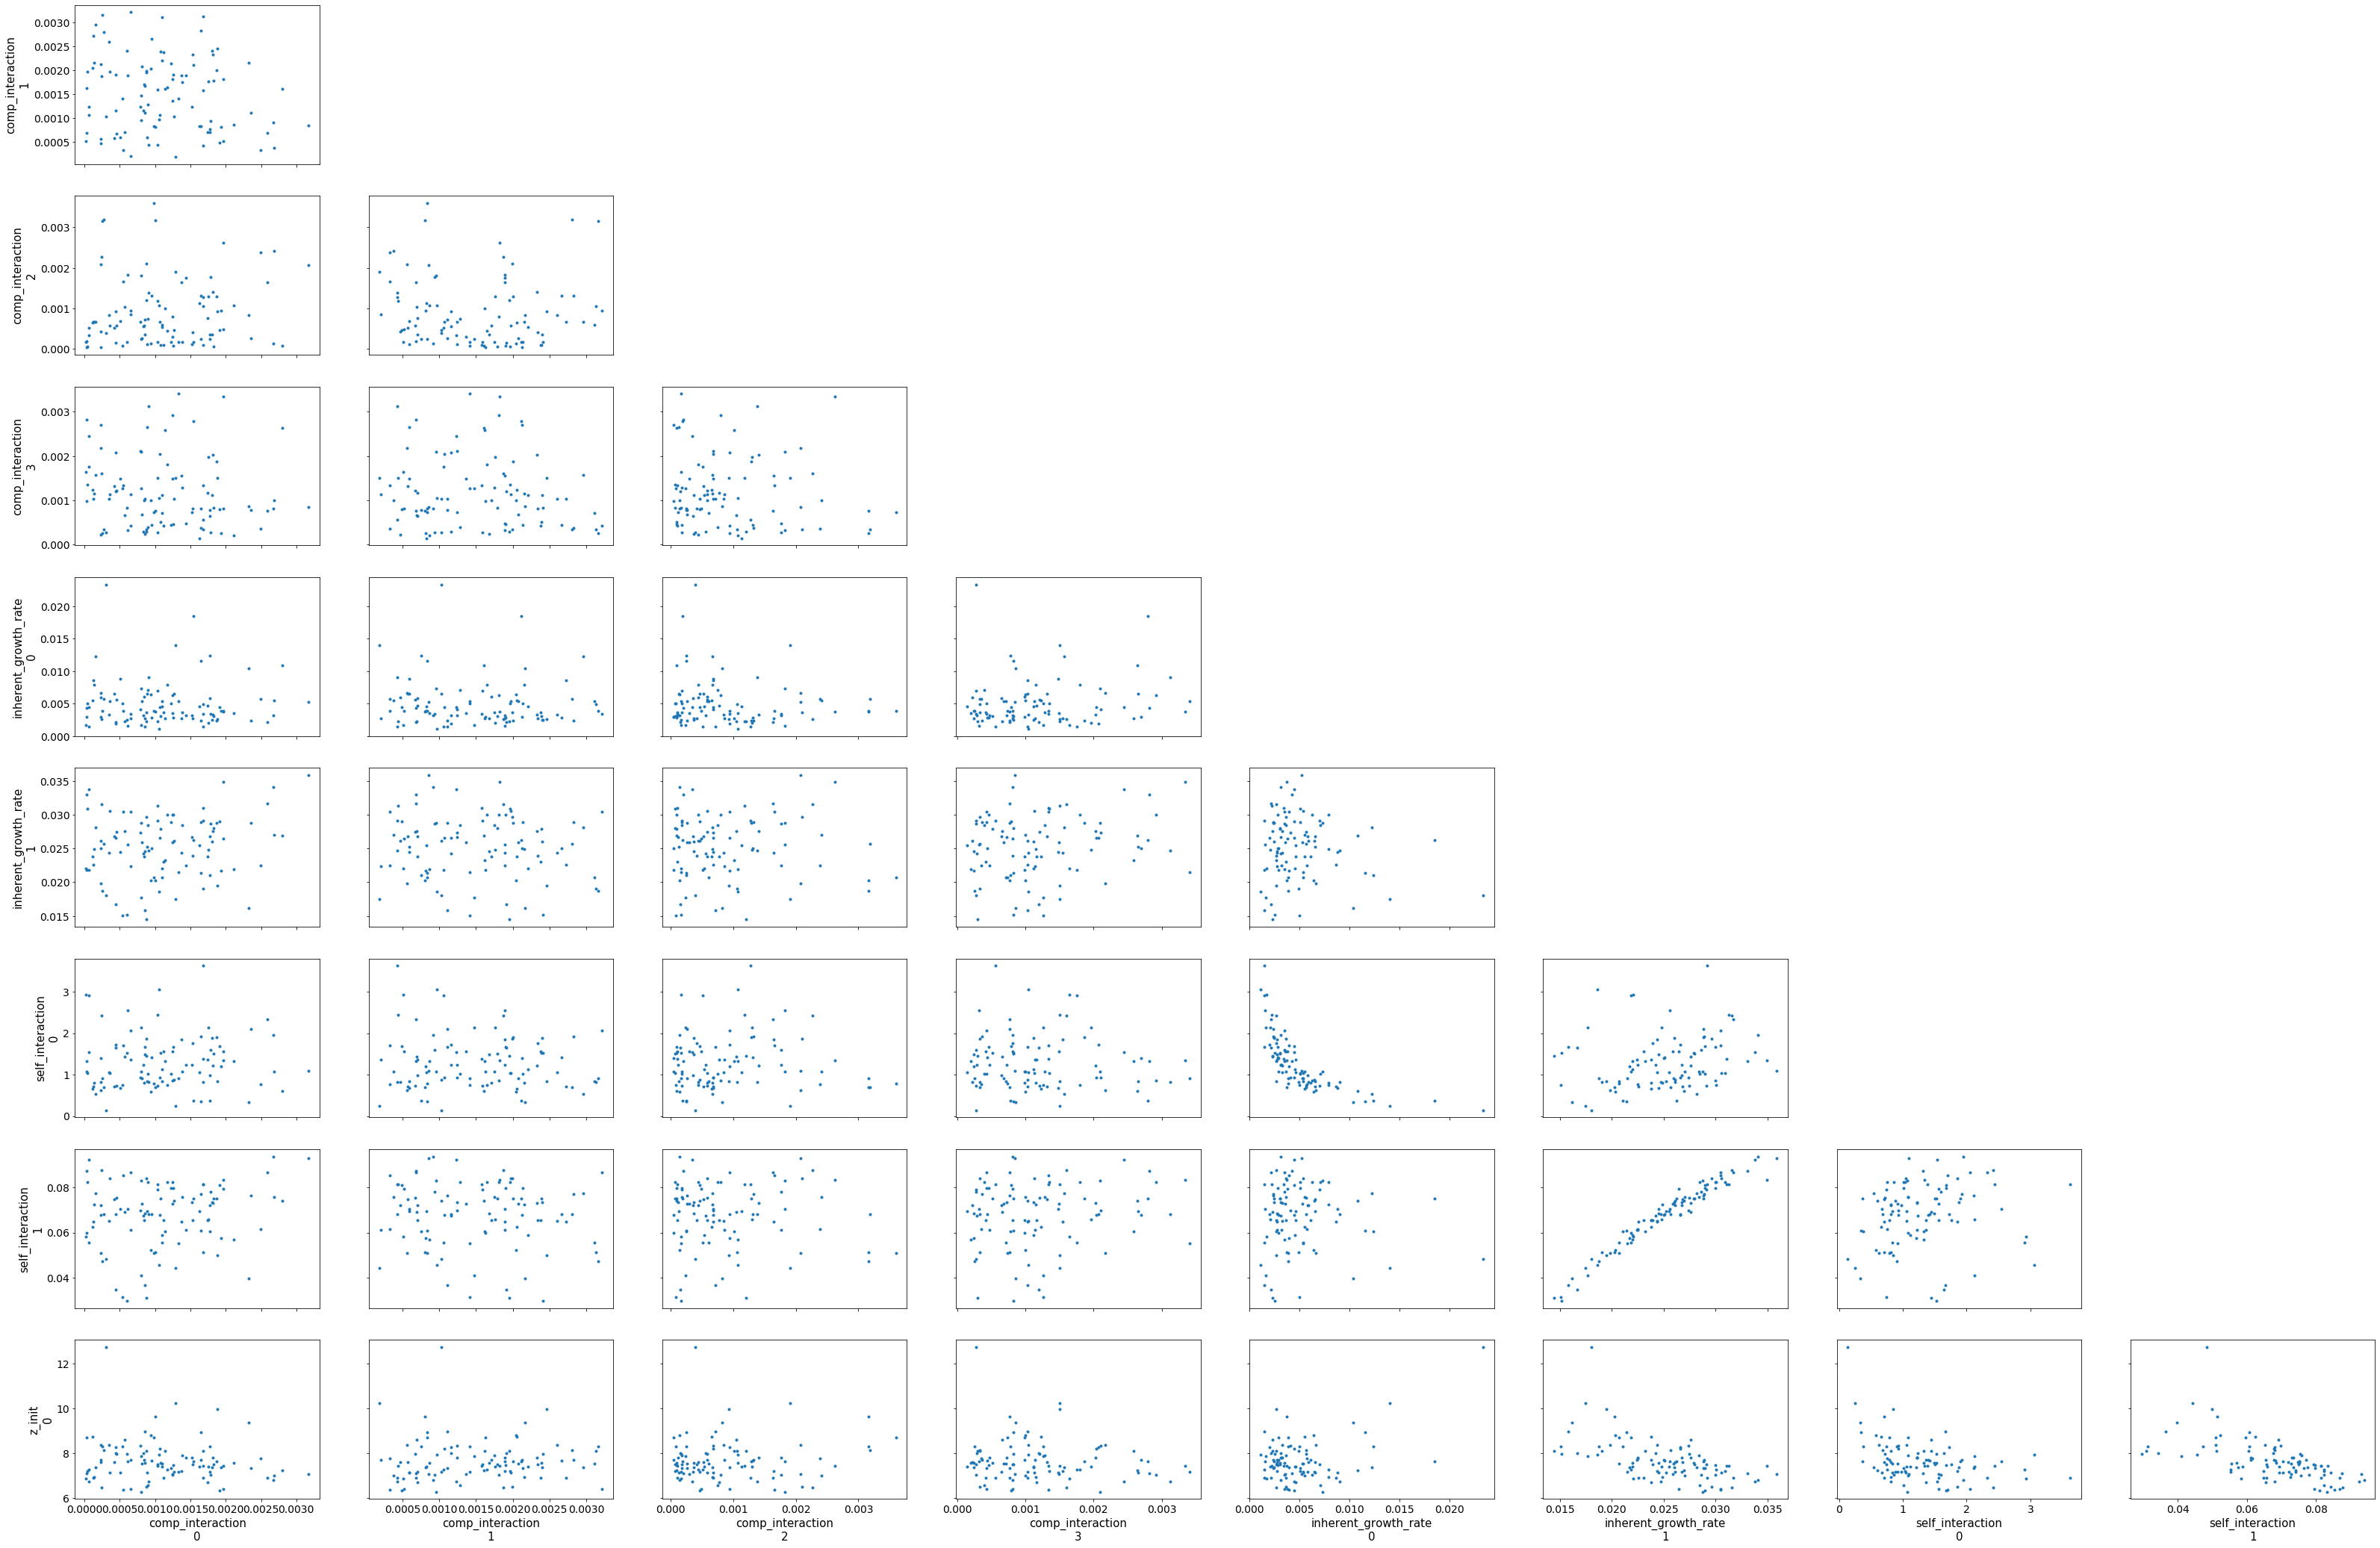

In [176]:
mcmc_from_numpyro = az.from_numpyro(mcmc)
az.plot_trace(mcmc_from_numpyro, compact = True, combined = True);
plt.show()

az.plot_forest(mcmc_from_numpyro, var_names = ['comp_interaction'], combined = True)
plt.show()

az.plot_forest(mcmc_from_numpyro, var_names = ['inherent_growth_rate'], combined = True)
plt.show()

az.plot_forest(mcmc_from_numpyro, var_names = ['self_interaction'], combined = True)
plt.show()

az.plot_forest(mcmc_from_numpyro, var_names = ['z_init'], combined = True)
plt.show()

az.plot_pair(mcmc_from_numpyro)
plt.show()

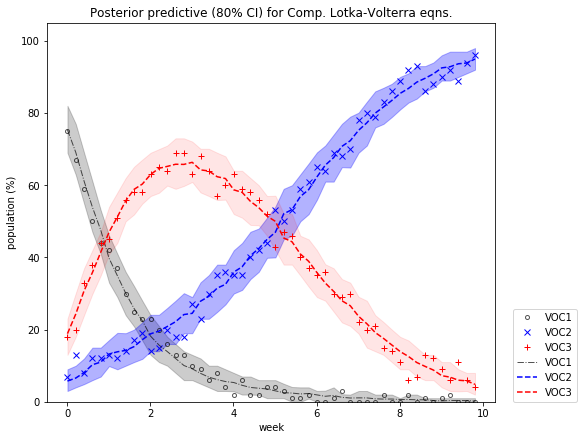

In [177]:
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), trans_data.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), np.percentile(pop_pred, (10, 90), 0)

plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(week, trans_data[:, 0], "ko", mfc="none", ms=4, label="VOC1", alpha=0.67)
plt.plot(week, trans_data[:, 1], "bx", label="VOC2")
plt.plot(week, trans_data[:, 2], "r+", label="VOC3")
# plt.plot(week, trans_data[:, 3], "g+", label="VOC4")
plt.plot(week, mu[:, 0], "k-.", label="VOC1", lw=1, alpha=0.67)
plt.plot(week, mu[:, 1], "b--", label="VOC2")
plt.plot(week, mu[:, 2], "r--", label="VOC3")
# plt.plot(week, mu[:, 3], "g--", label="VOC4")
plt.fill_between(week, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(week, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.fill_between(week, pi[0, :, 2], pi[1, :, 2], color="r", alpha=0.1)
# plt.fill_between(week, pi[0, :, 3], pi[1, :, 3], color="g", alpha=0.1)
plt.gca().set(ylim=(0, 105), xlabel="week", ylabel="population (%)")
plt.title("Posterior predictive (80% CI) for Comp. Lotka-Volterra eqns.")
plt.legend(loc=(1.04,0))
plt.show()